filter == kernel

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
os.listdir("kagglecatsanddogs_3367a")

['MSR-LA - 3467.docx', 'PetImages', 'readme[1].txt']

In [32]:
class Preprocessor:
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    catcount, dogcount = 0, 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
            
                    if label == self.CATS:
                        self.catcount += 1
                    if label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    # print(e)
                    continue
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)


In [33]:
p = Preprocessor()
p.make_training_data()

  0%|          | 35/12501 [00:00<00:36, 346.13it/s]

kagglecatsanddogs_3367a/PetImages/Cat


  1%|          | 37/7247 [00:00<00:19, 365.09it/s]

kagglecatsanddogs_3367a/PetImages/Dog


100%|██████████| 7247/7247 [00:20<00:00, 352.72it/s]


Cats:  12476
Dogs:  7221


In [37]:
train = np.load('training_data.npy', allow_pickle = True)
train.shape

(19697, 2)

[1. 0.]


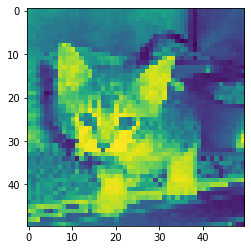

In [50]:
print(train[0][1])
plt.imshow(train[0][0])

In [69]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # input, num of featuers, kernel size
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.adapt = nn.AdaptiveMaxPool2d((2, 2))
        
        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = self.adapt(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 1)

        return x
        
net = Net()

In [72]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [76]:
X = torch.Tensor([tr_data[0] for tr_data in train]).view(-1, 50, 50)
X = X / 255.0
y = torch.Tensor([tr_data[1] for tr_data in train])

In [77]:
VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
val_size

1969

In [79]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [92]:
BATCH_SIZE = 100
EPOCHS = 3

In [86]:
train_X[0].shape

torch.Size([50, 50])

In [93]:
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i + BATCH_SIZE]
        
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    print(loss)

  0%|          | 0/178 [00:00<?, ?it/s]

tensor(0.1922, grad_fn=<MseLossBackward>)


  0%|          | 0/178 [00:00<?, ?it/s]

tensor(0.1363, grad_fn=<MseLossBackward>)


100%|██████████| 178/178 [01:15<00:00,  2.35it/s]

tensor(0.1177, grad_fn=<MseLossBackward>)


In [94]:
correct, total = 0, 0
with torch.no_grad():
    for i in tqdm(range(test_X.shape[0])):
        real = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted = torch.argmax(net_out)
        if predicted == real:
            correct += 1
        total += 1
    
print(f'acc: {correct / total}')

100%|██████████| 1969/1969 [00:04<00:00, 468.65it/s]

acc: 0.7521584560690706


### Cuda port

In [96]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [97]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (adapt): AdaptiveMaxPool2d(output_size=(2, 2))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [98]:
def train(net):
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i + BATCH_SIZE]
            
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        print(loss)

In [99]:
def test(net):
    correct, total = 0, 0
    with torch.no_grad():
        for i in tqdm(range(test_X.shape[0])):
            real = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
            predicted = torch.argmax(net_out)
            if predicted == real:
                correct += 1
            total += 1
    
    print(f'acc: {correct / total}')

In [100]:
test(net)

100%|██████████| 1969/1969 [00:04<00:00, 420.49it/s]

acc: 0.7521584560690706
